In [6]:
from load_data import histograms, xu_masses, phi_masses

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROC Curve


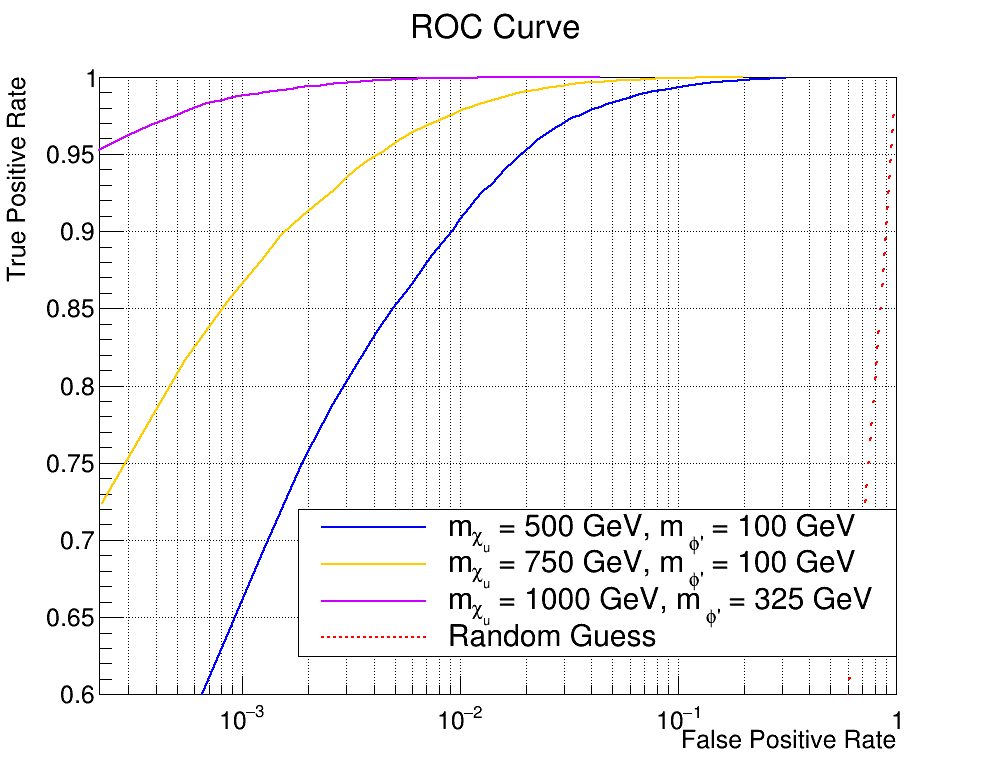

In [7]:
# Draw the ROC curve using ROOT
import ROOT
from ROOT import TGraph, TCanvas, TLine, TLegend
import numpy as np


def get_ROC_curve(xu_mass, phi_mass) -> TGraph:

    df = histograms[f"xu_{xu_mass}_phi_{phi_mass}"]

    df_copy = df.copy()
    bin_width = round(df["bin_center"][1] - df["bin_center"][0], 2)
    df_copy["left_edge"] = round(df_copy["bin_center"] - bin_width / 2, 2)
    df_copy["right_edge"] = round(df_copy["bin_center"] + bin_width / 2, 2)

    df = df_copy
    df

    thresholds = df["left_edge"].tolist()[1:]
    thresholds

    def get_tpr_fpr(histogram, threshold):
        tp = histogram[histogram["bin_center"] < threshold]["signal"].sum()
        fp = histogram[histogram["bin_center"] < threshold]["background"].sum()
        return (
            tp / histogram["signal"].sum(),
            fp / histogram["background"].sum(),
        )

    tprs = [get_tpr_fpr(df, threshold)[0] for threshold in thresholds]
    fprs = [get_tpr_fpr(df, threshold)[1] for threshold in thresholds]

    tpr_array = np.array(tprs)
    fpr_array = np.array(fprs)

    roc_curve = TGraph(len(tpr_array), fpr_array, tpr_array)
    return roc_curve


canvas = TCanvas("ROC Curve", "ROC Curve", 1000, 800)
canvas.SetGrid()
canvas.SetLogx()

values = (500, 100)
roc_curve = get_ROC_curve(xu_mass=values[0], phi_mass=values[1])
roc_curve.SetTitle("ROC Curve")
roc_curve.GetXaxis().SetTitle("False Positive Rate")
roc_curve.GetYaxis().SetTitle("True Positive Rate")
# Set Range
roc_curve.GetXaxis().SetLimits(2.20e-4, 1)
roc_curve.GetHistogram().SetMaximum(1)
roc_curve.GetHistogram().SetMinimum(0.6)

roc_curve.SetLineColor(ROOT.kBlue)
roc_curve.SetLineWidth(2)
roc_curve.Draw("AL")

values_2 = (750, 100)
roc_2 = get_ROC_curve(xu_mass=values_2[0], phi_mass=values_2[1])
roc_2.SetLineColor(ROOT.kOrange)
roc_2.SetLineWidth(2)
roc_2.Draw("SAME")

values_3 = (1000, 325)
roc_3 = get_ROC_curve(xu_mass=values_3[0], phi_mass=values_3[1])
roc_3.SetLineColor(ROOT.kViolet)
roc_3.SetLineWidth(2)
roc_3.Draw("SAME")


# Define the number of steps
n = 50
x = [i / n for i in range(n + 1)]
y = [i / n for i in range(n + 1)]
diag = TGraph(n, np.array(x), np.array(y))
diag.SetLineColor(ROOT.kRed)
diag.SetLineWidth(2)
diag.SetLineStyle(2)
diag.Draw("SAME")


# Legend
legend = TLegend(0.30, 0.15, 0.9, 0.34)
legend.AddEntry(
    roc_curve,
    f"m_{{#chi_{{u}}}} = {values[0]} GeV, m_{{#phi'}} = {values[1]} GeV",
    "L",
)
legend.AddEntry(
    roc_2,
    f"m_{{#chi_{{u}}}} = {values_2[0]} GeV, m_{{#phi'}} = {values_2[1]} GeV",
    "L",
)
legend.AddEntry(
    roc_3,
    f"m_{{#chi_{{u}}}} = {values_3[0]} GeV, m_{{#phi'}} = {values_3[1]} GeV",
    "L",
)
legend.AddEntry(diag, "Random Guess", "L")
legend.Draw()

canvas.Draw()

In [8]:
canvas.SaveAs("ROC_Curve.png")
canvas.SaveAs("ROC_Curve.pdf")

Info in <TCanvas::Print>: png file ROC_Curve.png has been created
Info in <TCanvas::Print>: pdf file ROC_Curve.pdf has been created


In [9]:
xu_mass = 500
phi_mass = 100
df = histograms[f"xu_{xu_mass}_phi_{phi_mass}"]
df.head()

,bin_center,signal,ttbarmumu,ttbarmumumunu,background
0,0.01,10288.379949,0.256678,0.012059,0.268738
1,0.03,1917.680656,0.286814,0.015298,0.302112
2,0.05,1001.324476,0.282377,0.015921,0.298298
3,0.07,642.452014,0.309097,0.013962,0.323059
4,0.09,462.488060,0.328654,0.014086,0.342741


In [10]:

import itertools

def plot_xgb_output(xu_mass, phi_mass):
    from ROOT import TH1F, TCanvas, TLegend, TLatex, TColor
    df = histograms[f"xu_{xu_mass}_phi_{phi_mass}"]

    n_bins = len(df["bin_center"])

    signal_histo = TH1F(f"xu_{xu_mass}_phi_{phi_mass}_signal", "signal_histo", n_bins, 0, 1)
    bkg1_histo = TH1F(f"xu_{xu_mass}_phi_{phi_mass}_bkg1", "bkg1_histo", n_bins, 0, 1)
    bkg2_histo = TH1F(f"xu_{xu_mass}_phi_{phi_mass}_bkg2", "bkg2_histo", n_bins, 0, 1)
    for i in range(n_bins):
        signal_histo.SetBinContent(i + 1, df["signal"][i])
        bkg1_histo.SetBinContent(i + 1, df["ttbarmumu"][i])
        bkg2_histo.SetBinContent(i + 1, df["ttbarmumumunu"][i])
    
    signal_histo.Scale(1 / signal_histo.Integral())
    bkg1_histo.Scale(1 / bkg1_histo.Integral())
    bkg2_histo.Scale(1 / bkg2_histo.Integral())


    signal_histo.SetStats(False)
    bkg1_histo.SetStats(False)
    bkg2_histo.SetStats(False)

    canvas = TCanvas(f"xu_{xu_mass}_phi_{phi_mass}_canvas", "XGB_output", 1000, 800)
    canvas.SetGrid()
    canvas.SetLogy()
    signal_color = TColor.GetColor(88, 210, 83)
    signal_histo.SetLineColor(signal_color)
    signal_histo.SetLineWidth(2)
    signal_histo.SetTitle("")
    signal_histo.GetXaxis().SetTitle("XGB output")
    signal_histo.GetYaxis().SetTitle("[A.U]")
    # set x and y axis limits
    signal_histo.GetXaxis().SetRangeUser(0, 1)
    signal_histo.GetYaxis().SetRangeUser(1.5e-4, 1)
    signal_histo.Draw("hist")
    bkg1_color = TColor.GetColor(88,83,215)
    bkg1_histo.SetLineColor(bkg1_color)
    bkg1_histo.SetLineWidth(2)
    bkg1_histo.Draw("hist SAME")
    bkg2_color = TColor.GetColor(255,83,255)
    bkg2_histo.SetLineColor(bkg2_color)
    bkg2_histo.SetLineWidth(2)
    bkg2_histo.Draw("hist SAME")

    text = TLatex()
    text.SetTextSize(0.04)
    text.DrawLatexNDC(0.76, 0.92, f"#sqrt{{s}}=13 TeV")


    legend = TLegend(0.2, 0.75, 0.8, 0.90)
    legend.AddEntry(signal_histo, f"m_{{#chi_{{u}}}} = {xu_mass} GeV, m_{{#phi'}} = {phi_mass} GeV", "L")
    legend.AddEntry(bkg1_histo, "p p #rightarrow t#bar{t} #mu#mu", "L")
    legend.AddEntry(bkg2_histo, "p p #rightarrow t#bar{t} #mu#mu#nu#nu", "L")
    legend.Draw()
    canvas.Draw()
    canvas.SaveAs(f"images/xu_{xu_mass}_GeV/phi_{phi_mass}_GeV/XGB_output.png")
    canvas.SaveAs(f"images/xu_{xu_mass}_GeV/phi_{phi_mass}_GeV/XGB_output.pdf")
l=list(map(lambda x: plot_xgb_output(*x), itertools.product(xu_masses, phi_masses)))

Info in <TCanvas::Print>: png file images/xu_500_GeV/phi_1_GeV/XGB_output.png has been created
Info in <TCanvas::Print>: pdf file images/xu_500_GeV/phi_1_GeV/XGB_output.pdf has been created
Info in <TCanvas::Print>: png file images/xu_500_GeV/phi_5_GeV/XGB_output.png has been created
Info in <TCanvas::Print>: pdf file images/xu_500_GeV/phi_5_GeV/XGB_output.pdf has been created
Info in <TCanvas::Print>: png file images/xu_500_GeV/phi_10_GeV/XGB_output.png has been created
Info in <TCanvas::Print>: pdf file images/xu_500_GeV/phi_10_GeV/XGB_output.pdf has been created
Info in <TCanvas::Print>: png file images/xu_500_GeV/phi_50_GeV/XGB_output.png has been created
Info in <TCanvas::Print>: pdf file images/xu_500_GeV/phi_50_GeV/XGB_output.pdf has been created
Info in <TCanvas::Print>: png file images/xu_500_GeV/phi_100_GeV/XGB_output.png has been created
Info in <TCanvas::Print>: pdf file images/xu_500_GeV/phi_100_GeV/XGB_output.pdf has been created
Info in <TCanvas::Print>: png file images/